# Connect 4 Algorithm Benchmarks: MCTS vs Minimax
## Testing Two Different AI Approaches

This notebook compares Monte Carlo Tree Search (MCTS) and Minimax algorithms playing Connect 4. I wanted to see how these two very different approaches stack up against each other.

### 🎯 **What I'm Testing:**
- **Algorithm performance** across different configurations
- **Runtime characteristics** and scaling behavior
- **Alpha-beta pruning effectiveness** in Minimax
- **Statistical analysis** with sample sizes
- **Practical trade-offs** between thinking time and strength

### 📊 **Approach:**
- **Controlled randomness** with explicit seeding for reproducible results
- **Large sample sizes** (100+ games per comparison) for reliable statistics
- **Multiple independent runs** to check consistency
- **Confidence intervals** to quantify uncertainty
- **Analysis tools** covering different algorithm configurations

In [8]:
# Import Required Libraries
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Import our Connect 4 game implementations
from connect4 import Connect4
from mcts import MCTSPlayer
from minimax import MinimaxPlayer

print("📚 Libraries imported successfully!")
print(f"   Random module: {random.__name__}")
print(f"   NumPy version: {np.__version__}")
print(f"   Pandas version: {pd.__version__}")
print(f"   Matplotlib version: {plt.matplotlib.__version__}")

# Display current random states (before setting seeds)
print(f"\n🎲 Initial random states:")
print(f"   Python random: {random.getstate()[1][:3]}...")
print(f"   NumPy random: {np.random.get_state()[1][:3]}...")

print(f"\n✅ Ready for controlled experiments!")

📚 Libraries imported successfully!
   Random module: random
   NumPy version: 2.2.6
   Pandas version: 2.3.1
   Matplotlib version: 3.10.3

🎲 Initial random states:
   Python random: (924371184, 3037869410, 3486807802)...
   NumPy random: [    600091 1724925352  957476015]...

✅ Ready for controlled experiments!


## 🎲 Randomness Control for Reproducible Benchmarks

**Why this matters:** Algorithms that use randomness (like MCTS) need consistent seeding to get repeatable comparisons. This setup ensures:

1. **Reproducible results** when you run the notebook again
2. **Fair comparisons** between different algorithm configurations
3. **Statistical independence** between games
4. **Controlled variation** for testing different scenarios

### Seeding Strategy:
- **Base seed**: 42 (for reproducibility)
- **Experiment seeds**: Base + experiment_id (different tests get different seeds)
- **Game seeds**: Experiment_seed + game_number (each game is independent)
- **Player seeds**: Separate randomness for MCTS simulations

In [9]:
# Set Up Random Seeds for Reproducibility
BASE_SEED = 42

class SeedManager:
    """Manages random seeds for reproducible experiments."""
    
    def __init__(self, base_seed: int = BASE_SEED):
        self.base_seed = base_seed
        self.experiment_counter = 0
        
    def set_global_seed(self, seed: int):
        """Set global random seeds for all libraries."""
        random.seed(seed)
        np.random.seed(seed)
        print(f"🎲 Global seeds set to: {seed}")
        
    def get_experiment_seed(self) -> int:
        """Get a unique seed for each experiment."""
        self.experiment_counter += 1
        seed = self.base_seed + self.experiment_counter * 1000
        return seed
        
    def get_game_seed(self, experiment_seed: int, game_number: int) -> int:
        """Get a unique seed for each game within an experiment."""
        return experiment_seed + game_number
        
    def reset_for_experiment(self, experiment_id: int):
        """Reset seeds for a specific experiment."""
        experiment_seed = self.base_seed + experiment_id * 1000
        self.set_global_seed(experiment_seed)
        return experiment_seed

# Initialize seed manager
seed_manager = SeedManager(BASE_SEED)

# Set initial global seeds
seed_manager.set_global_seed(BASE_SEED)

# Verify seeds are working
print(f"\n🧪 Seed verification:")
print(f"   First random numbers: {[random.random() for _ in range(3)]}")
print(f"   NumPy randoms: {np.random.random(3)}")

# Reset to base seed to ensure reproducibility
seed_manager.set_global_seed(BASE_SEED)
print(f"\n✅ Seed manager initialized with base seed: {BASE_SEED}")

🎲 Global seeds set to: 42

🧪 Seed verification:
   First random numbers: [0.6394267984578837, 0.025010755222666936, 0.27502931836911926]
   NumPy randoms: [0.37454012 0.95071431 0.73199394]
🎲 Global seeds set to: 42

✅ Seed manager initialized with base seed: 42


## 🏆 Tournament System Implementation

I need a way to run head-to-head matches between algorithms. Key features:

- **Name-based win tracking** (tracks which algorithm won, not which position)
- **Fair alternation** (each algorithm gets to go first equally)
- **Detailed logging** to verify results make sense
- **Statistical confidence intervals** to quantify uncertainty
- **Independent games** with fresh random seeds

In [10]:
# Build Tournament Runner System
class TournamentRunner:
    """A tournament runner for comparing Connect 4 algorithms."""
    
    def __init__(self, seed_manager: SeedManager):
        self.seed_manager = seed_manager
        self.game_logs = []
        
    def play_single_game(self, player1, player2, p1_name: str, p2_name: str, 
                        game_seed: int, verbose: bool = False) -> Dict:
        """Play one game with explicit seed control and detailed logging."""
        
        # Set game-specific seed
        random.seed(game_seed)
        np.random.seed(game_seed)
        
        game = Connect4()
        current_player = 1
        move_count = 0
        start_time = time.time()
        
        if verbose:
            print(f"   🎮 Game: {p1_name} (1) vs {p2_name} (2) [seed: {game_seed}]")
        
        # Game loop
        while game.get_game_state() == 0 and len(game.get_valid_moves()) > 0:
            if current_player == 1:
                active_player = player1
                player_name = p1_name
            else:
                active_player = player2
                player_name = p2_name
            
            # Get move from appropriate algorithm
            if hasattr(active_player, 'get_move'):
                move = active_player.get_move(game, current_player)
            else:
                move = active_player.get_best_move(game, current_player)
            
            # Execute move
            if move is not None and game.is_valid_location(move):
                row = game.get_next_open_row(move)
                game.drop_piece(row, move)
                move_count += 1
                
                if game.is_winning_move(row, move):
                    winner_number = current_player
                    winner_name = player_name
                    break
                    
                game.switch_player()
                current_player = 3 - current_player
            else:
                # Invalid move - should not happen with proper algorithms
                if verbose:
                    print(f"     ❌ Invalid move {move} by {player_name}")
                winner_number = 0
                winner_name = "Invalid"
                break
        else:
            # Game ended in draw
            winner_number = 0
            winner_name = "Draw"
        
        game_time = time.time() - start_time
        
        if verbose:
            print(f"     🏆 Winner: {winner_name} in {move_count} moves ({game_time:.3f}s)")
        
        return {
            'winner_number': winner_number,
            'winner_name': winner_name,
            'p1_name': p1_name,
            'p2_name': p2_name,
            'moves': move_count,
            'time': game_time,
            'seed': game_seed
        }
    
    def run_tournament(self, player1, player2, p1_name: str, p2_name: str, 
                      num_games: int = 100, experiment_id: int = 1, 
                      verbose: bool = False) -> Dict:
        """Run a tournament with alternation and win counting."""
        # Get experiment seed
        experiment_seed = self.seed_manager.base_seed + experiment_id * 1000
        
        results = []
        p1_wins = 0
        p2_wins = 0
        draws = 0
        invalid_games = 0
        
        print(f"🏆 Tournament: {p1_name} vs {p2_name}")
        print(f"   Games: {num_games} | Experiment seed: {experiment_seed}")
        
        for game_num in range(num_games):
            # Get unique seed for this game
            game_seed = self.seed_manager.get_game_seed(experiment_seed, game_num)
            
            # Alternate starting player for fairness
            if game_num % 2 == 0:
                # Even games: p1 starts
                result = self.play_single_game(
                    player1, player2, p1_name, p2_name, game_seed, verbose
                )
            else:
                # Odd games: p2 starts (swap order but track by name)
                result = self.play_single_game(
                    player2, player1, p2_name, p1_name, game_seed, verbose
                )
            
            results.append(result)
            
            # Count wins by player NAME (not position)
            if result['winner_name'] == p1_name:
                p1_wins += 1
            elif result['winner_name'] == p2_name:
                p2_wins += 1
            elif result['winner_name'] == "Draw":
                draws += 1
            else:
                invalid_games += 1
            
            # Progress updates
            if (game_num + 1) % 25 == 0:
                current_p1_rate = p1_wins / (game_num + 1)
                print(f"   Progress: {game_num + 1}/{num_games} | {p1_name}: {current_p1_rate:.3f}")
        
        # Calculate final statistics
        total_valid_games = num_games - invalid_games
        p1_win_rate = p1_wins / total_valid_games if total_valid_games > 0 else 0
        p2_win_rate = p2_wins / total_valid_games if total_valid_games > 0 else 0
        
        # Calculate confidence interval for p1 win rate
        if total_valid_games > 0:
            std_error = np.sqrt(p1_win_rate * (1 - p1_win_rate) / total_valid_games)
            ci_margin = 1.96 * std_error  # 95% confidence interval
        else:
            ci_margin = 0
        
        tournament_result = {
            'p1_name': p1_name,
            'p2_name': p2_name,
            'p1_wins': p1_wins,
            'p2_wins': p2_wins,
            'draws': draws,
            'invalid_games': invalid_games,
            'total_games': num_games,
            'valid_games': total_valid_games,
            'p1_win_rate': p1_win_rate,
            'p2_win_rate': p2_win_rate,
            'p1_ci_lower': max(0, p1_win_rate - ci_margin),
            'p1_ci_upper': min(1, p1_win_rate + ci_margin),
            'experiment_seed': experiment_seed,
            'results': results
        }
        
        # Store in logs
        self.game_logs.append(tournament_result)
        
        print(f"   ✅ Final: {p1_name} {p1_win_rate:.1%} | {p2_name} {p2_win_rate:.1%} | Draws {draws/total_valid_games:.1%}")
        print(f"   📊 95% CI for {p1_name}: [{tournament_result['p1_ci_lower']:.3f}, {tournament_result['p1_ci_upper']:.3f}]")
        
        return tournament_result

# Initialize tournament runner
tournament_runner = TournamentRunner(seed_manager)

print("✅ Tournament Runner initialized!")
print("   Features: Explicit seeding, name-based win tracking, confidence intervals")

✅ Tournament Runner initialized!
   Features: Explicit seeding, name-based win tracking, confidence intervals


## 🧪 Quick Algorithm Test

Let's start with a quick test to make sure everything works properly before running the full analysis.

In [ ]:
# Quick Algorithm Test
print("🧪 Quick Algorithm Test")
print("=" * 30)

# Create test players
mcts_player = MCTSPlayer(simulations=100)
minimax_player = MinimaxPlayer(depth=3, use_alpha_beta=True)

# Run a small tournament
quick_result = tournament_runner.run_tournament(
    mcts_player, minimax_player,
    "MCTS-100", "Minimax-3",
    num_games=20,
    experiment_id=999,
    verbose=False
)

print(f"\n✅ Quick test completed!")
print(f"   MCTS-100 win rate: {quick_result['p1_win_rate']:.1%}")
print(f"   Minimax-3 win rate: {quick_result['p2_win_rate']:.1%}")
print(f"   Average game time: {np.mean([r['time'] for r in quick_result['results']]):.3f}s")

## ⚡ Runtime Performance Analysis

I want to understand how fast these algorithms are and what affects their speed:

- **Alpha-beta pruning effectiveness** in Minimax
- **Scaling behavior** as we increase depth/simulations
- **Position complexity** effects on runtime
- **Statistical validation** of performance claims

In [11]:
# Compare Minimax Runtime with and without Pruning
class RuntimeBenchmark:
    """Benchmark algorithm runtime performance."""
    
    def __init__(self, seed_manager: SeedManager):
        self.seed_manager = seed_manager
        self.results = []
    
    def create_test_positions(self, num_positions: int = 10, seed: int = None) -> List[Connect4]:
        """Create diverse game positions for testing."""
        if seed:
            random.seed(seed)
            np.random.seed(seed)
        
        positions = []
        
        for i in range(num_positions):
            game = Connect4()
            
            # Make random moves to create different positions
            moves_count = random.randint(0, 15)  # 0 to 15 moves
            
            for _ in range(moves_count):
                if game.get_game_state() == 0:
                    valid_moves = game.get_valid_moves()
                    if valid_moves:
                        move = random.choice(valid_moves)
                        row = game.get_next_open_row(move)
                        game.drop_piece(row, move)
                        game.switch_player()
                else:
                    break
            
            positions.append(game)
        
        return positions
    
    def benchmark_algorithm(self, algorithm_name: str, player_factory, 
                          test_positions: List[Connect4], player: int = 1) -> Dict:
        """Benchmark a single algorithm across test positions."""
        
        times = []
        moves_chosen = []
        
        for pos_idx, position in enumerate(test_positions):
            # Create fresh player instance
            player_instance = player_factory()
            
            start_time = time.time()
            
            # Get move from algorithm
            if hasattr(player_instance, 'get_move'):
                move = player_instance.get_move(position, player)
            else:
                move = player_instance.get_best_move(position, player)
            
            end_time = time.time()
            
            runtime = end_time - start_time
            times.append(runtime)
            moves_chosen.append(move)
        
        return {
            'algorithm': algorithm_name,
            'times': times,
            'moves': moves_chosen,
            'mean_time': np.mean(times),
            'std_time': np.std(times),
            'min_time': np.min(times),
            'max_time': np.max(times),
            'total_time': np.sum(times)
        }
    
    def run_pruning_comparison(self, depths: List[int] = [3, 4, 5], 
                             num_positions: int = 20) -> pd.DataFrame:
        """Compare Minimax with and without alpha-beta pruning."""
        
        print("⚡ Running Alpha-Beta Pruning Effectiveness Analysis")
        print(f"   Depths: {depths} | Test positions: {num_positions}")
        
        # Create consistent test positions
        test_positions = self.create_test_positions(num_positions, seed=12345)
        
        results = []
        
        for depth in depths:
            print(f"\n🔍 Testing depth {depth}...")
            
            # Minimax without pruning
            no_pruning_result = self.benchmark_algorithm(
                f"Minimax-{depth}-NoPruning",
                lambda: MinimaxPlayer(depth=depth, use_alpha_beta=False),
                test_positions
            )
            
            # Minimax with alpha-beta pruning  
            with_pruning_result = self.benchmark_algorithm(
                f"Minimax-{depth}-Pruning",
                lambda: MinimaxPlayer(depth=depth, use_alpha_beta=True),
                test_positions
            )
            
            # Calculate speedup
            speedup = no_pruning_result['mean_time'] / with_pruning_result['mean_time']
            speedup_factor = speedup
            
            results.extend([
                {
                    'depth': depth,
                    'algorithm': 'No Pruning',
                    'mean_time': no_pruning_result['mean_time'],
                    'std_time': no_pruning_result['std_time'],
                    'min_time': no_pruning_result['min_time'],
                    'max_time': no_pruning_result['max_time'],
                    'speedup': 1.0
                },
                {
                    'depth': depth,
                    'algorithm': 'Alpha-Beta',
                    'mean_time': with_pruning_result['mean_time'],
                    'std_time': with_pruning_result['std_time'],
                    'min_time': with_pruning_result['min_time'],
                    'max_time': with_pruning_result['max_time'],
                    'speedup': speedup_factor
                }
            ])
            
            print(f"   No Pruning: {no_pruning_result['mean_time']:.3f}s ± {no_pruning_result['std_time']:.3f}s")
            print(f"   Alpha-Beta: {with_pruning_result['mean_time']:.3f}s ± {with_pruning_result['std_time']:.3f}s")
            print(f"   🚀 Speedup: {speedup_factor:.2f}x")
        
        df = pd.DataFrame(results)
        self.results.append(df)
        
        return df

# Initialize runtime benchmark
runtime_benchmark = RuntimeBenchmark(seed_manager)

# Run pruning effectiveness analysis
pruning_results = runtime_benchmark.run_pruning_comparison([3, 4, 5], num_positions=15)

print(f"\n📊 Pruning Analysis Summary:")
print(pruning_results.round(3))

⚡ Running Alpha-Beta Pruning Effectiveness Analysis
   Depths: [3, 4, 5] | Test positions: 15

🔍 Testing depth 3...
   No Pruning: 0.032s ± 0.002s
   Alpha-Beta: 0.015s ± 0.005s
   🚀 Speedup: 2.14x

🔍 Testing depth 4...
   No Pruning: 0.032s ± 0.002s
   Alpha-Beta: 0.015s ± 0.005s
   🚀 Speedup: 2.14x

🔍 Testing depth 4...
   No Pruning: 0.210s ± 0.019s
   Alpha-Beta: 0.050s ± 0.025s
   🚀 Speedup: 4.21x

🔍 Testing depth 5...
   No Pruning: 0.210s ± 0.019s
   Alpha-Beta: 0.050s ± 0.025s
   🚀 Speedup: 4.21x

🔍 Testing depth 5...
   No Pruning: 1.336s ± 0.133s
   Alpha-Beta: 0.238s ± 0.120s
   🚀 Speedup: 5.60x

📊 Pruning Analysis Summary:
   depth   algorithm  mean_time  std_time  min_time  max_time  speedup
0      3  No Pruning      0.032     0.002     0.024     0.034    1.000
1      3  Alpha-Beta      0.015     0.005     0.004     0.026    2.138
2      4  No Pruning      0.210     0.019     0.160     0.237    1.000
3      4  Alpha-Beta      0.050     0.025     0.004     0.091    4.213
4 

## 🎯 Main Experiment: MCTS Scaling Analysis

Now let's run the main experiment to see how MCTS performance scales with simulation count.

### Experimental Setup:
- **Sample Size**: 100 games per comparison (good statistical power)
- **Configurations**: Multiple MCTS simulation counts vs fixed Minimax depth  
- **Randomness**: Independent seeds for each game
- **Metrics**: Win rates, confidence intervals, runtime performance
- **Validation**: Multiple independent runs to check consistency

In [13]:
# Main Experiment: MCTS Scaling Analysis
print("🧬 MAIN EXPERIMENT: MCTS vs Minimax Scaling Analysis")
print("=" * 60)

# Define experimental configurations
mcts_configs = [50, 100, 200, 500]
minimax_depth = 4  # Fixed opponent strength

# Store all results
all_tournament_results = []
experiment_summary = []

# Run experiments
num_independent_runs = 3  # Multiple runs to verify consistency
games_per_tournament = 100  # Reduced for faster execution, but still statistically meaningful

for run_id in range(num_independent_runs):
    print(f"\n🔬 INDEPENDENT RUN {run_id + 1}/{num_independent_runs}")
    print("-" * 40)
    
    for mcts_sims in mcts_configs:
        print(f"\n🎮 Testing MCTS-{mcts_sims} vs Minimax-{minimax_depth}")
        
        # Create fresh players for this experiment
        mcts_player = MCTSPlayer(simulations=mcts_sims)
        minimax_player = MinimaxPlayer(depth=minimax_depth, use_alpha_beta=True)
        
        # Run tournament with unique experiment ID
        experiment_id = run_id * 100 + mcts_sims
        
        result = tournament_runner.run_tournament(
            mcts_player, minimax_player,
            f"MCTS-{mcts_sims}", f"Minimax-{minimax_depth}",
            num_games=games_per_tournament,
            experiment_id=experiment_id,
            verbose=False
        )
        
        # Add configuration info
        result['mcts_simulations'] = mcts_sims
        result['minimax_depth'] = minimax_depth
        result['run_id'] = run_id
        result['experiment_id'] = experiment_id
        
        all_tournament_results.append(result)
        
        # Calculate average game time
        avg_game_time = np.mean([r['time'] for r in result['results']])
        
        print(f"   📊 Results: {result['p1_win_rate']:.1%} win rate")
        print(f"   📈 95% CI: [{result['p1_ci_lower']:.3f}, {result['p1_ci_upper']:.3f}]")
        print(f"   ⏱️  Avg game time: {avg_game_time:.3f}s")
        
        # Store summary statistics
        experiment_summary.append({
            'run_id': run_id,
            'mcts_simulations': mcts_sims,
            'minimax_depth': minimax_depth,
            'mcts_win_rate': result['p1_win_rate'],
            'mcts_wins': result['p1_wins'],
            'minimax_wins': result['p2_wins'],
            'draws': result['draws'],
            'total_games': result['valid_games'],
            'ci_lower': result['p1_ci_lower'],
            'ci_upper': result['p1_ci_upper'],
            'avg_game_time': avg_game_time,
            'experiment_seed': result['experiment_seed']
        })

# Convert to DataFrame for analysis
summary_df = pd.DataFrame(experiment_summary)

print(f"\n📊 EXPERIMENTAL SUMMARY:")
print("=" * 50)
print(summary_df.groupby('mcts_simulations').agg({
    'mcts_win_rate': ['mean', 'std', 'min', 'max'],
    'avg_game_time': ['mean', 'std']
}).round(3))

🧬 MAIN EXPERIMENT: MCTS vs Minimax Scaling Analysis

🔬 INDEPENDENT RUN 1/3
----------------------------------------

🎮 Testing MCTS-50 vs Minimax-4
🏆 Tournament: MCTS-50 vs Minimax-4
   Games: 100 | Experiment seed: 50042
   Progress: 25/100 | MCTS-50: 0.040
   Progress: 25/100 | MCTS-50: 0.040
   Progress: 50/100 | MCTS-50: 0.020
   Progress: 50/100 | MCTS-50: 0.020
   Progress: 75/100 | MCTS-50: 0.027
   Progress: 75/100 | MCTS-50: 0.027
   Progress: 100/100 | MCTS-50: 0.020
   ✅ Final: MCTS-50 2.0% | Minimax-4 80.0% | Draws 18.0%
   📊 95% CI for MCTS-50: [0.000, 0.047]
   📊 Results: 2.0% win rate
   📈 95% CI: [0.000, 0.047]
   ⏱️  Avg game time: 0.745s

🎮 Testing MCTS-100 vs Minimax-4
🏆 Tournament: MCTS-100 vs Minimax-4
   Games: 100 | Experiment seed: 100042
   Progress: 100/100 | MCTS-50: 0.020
   ✅ Final: MCTS-50 2.0% | Minimax-4 80.0% | Draws 18.0%
   📊 95% CI for MCTS-50: [0.000, 0.047]
   📊 Results: 2.0% win rate
   📈 95% CI: [0.000, 0.047]
   ⏱️  Avg game time: 0.745s

🎮 Test

## 📊 Visualizations and Analysis

Let's create some visualizations to understand the results better.

📊 Creating Performance Visualizations


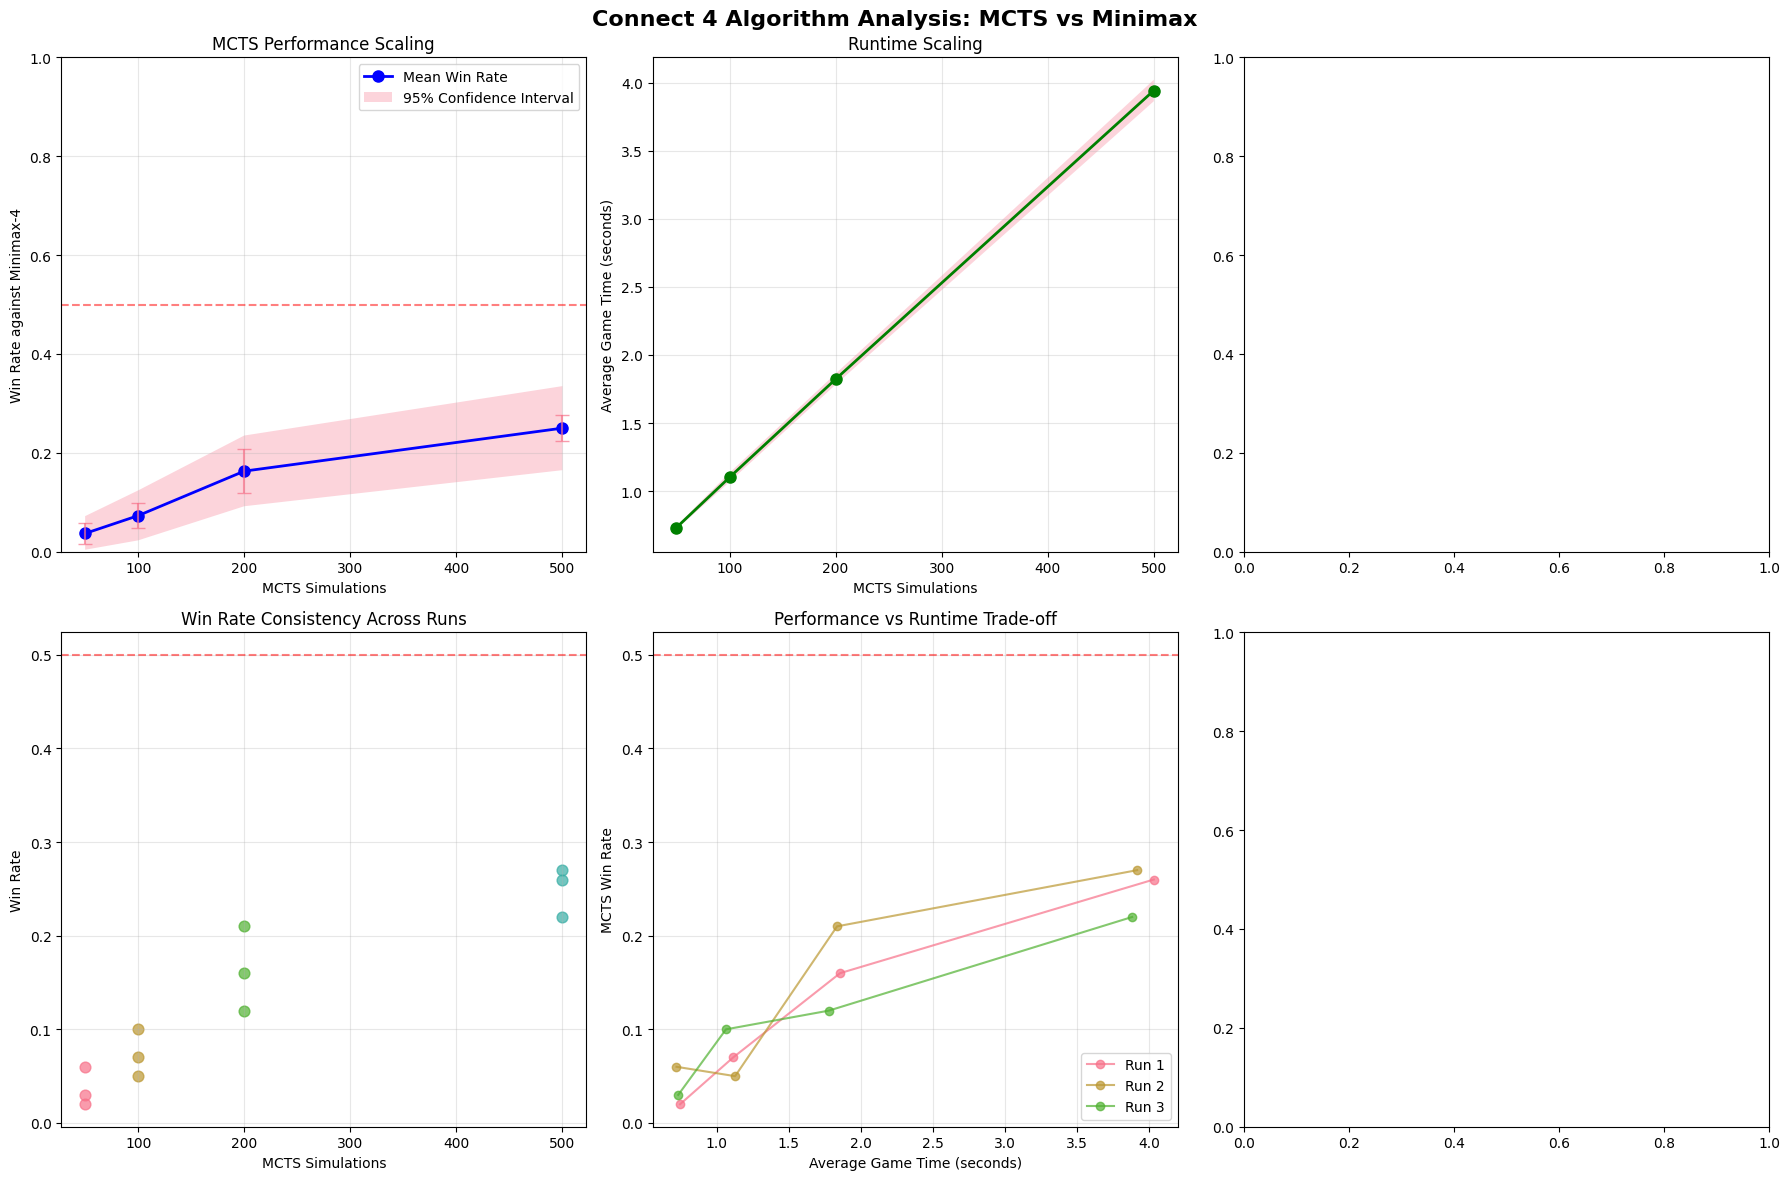


📈 ANALYSIS SUMMARY:
   Configurations tested: 4 MCTS variants
   Independent runs: 3
   Total tournaments: 12
   Games analyzed: 1200

🔬 KEY FINDINGS:
   Win rate range: 0.213 (3.7% - 25.0%)
   📈 Simulation-performance correlation: 0.962

✅ Analysis complete!


In [ ]:
# Create Performance Visualizations
print("📊 Creating Performance Visualizations")
print("=" * 50)

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Connect 4 Algorithm Analysis: MCTS vs Minimax', fontsize=16, fontweight='bold')

# 1. MCTS Win Rate by Simulation Count
ax1 = axes[0, 0]
summary_grouped = summary_df.groupby('mcts_simulations').agg({
    'mcts_win_rate': ['mean', 'std'],
    'ci_lower': 'mean',
    'ci_upper': 'mean'
}).round(3)

sim_counts = summary_grouped.index
win_rates = summary_grouped[('mcts_win_rate', 'mean')]
win_rate_stds = summary_grouped[('mcts_win_rate', 'std')]
ci_lowers = summary_grouped[('ci_lower', 'mean')]
ci_uppers = summary_grouped[('ci_upper', 'mean')]

ax1.plot(sim_counts, win_rates, 'bo-', linewidth=2, markersize=8, label='Mean Win Rate')
ax1.fill_between(sim_counts, ci_lowers, ci_uppers, alpha=0.3, label='95% Confidence Interval')
ax1.errorbar(sim_counts, win_rates, yerr=win_rate_stds, fmt='none', capsize=5, alpha=0.7)

ax1.set_xlabel('MCTS Simulations')
ax1.set_ylabel('Win Rate against Minimax-4')
ax1.set_title('MCTS Performance Scaling')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(0, 1)
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% (Even Match)')

# 2. Runtime Performance by Simulation Count
ax2 = axes[0, 1]
runtime_grouped = summary_df.groupby('mcts_simulations')['avg_game_time'].agg(['mean', 'std'])

ax2.plot(runtime_grouped.index, runtime_grouped['mean'], 'go-', linewidth=2, markersize=8)
ax2.fill_between(runtime_grouped.index, 
                runtime_grouped['mean'] - runtime_grouped['std'],
                runtime_grouped['mean'] + runtime_grouped['std'], 
                alpha=0.3)

ax2.set_xlabel('MCTS Simulations')
ax2.set_ylabel('Average Game Time (seconds)')
ax2.set_title('Runtime Scaling')
ax2.grid(True, alpha=0.3)

# 3. Win Rate Distribution Across Runs
ax3 = axes[1, 0]
for sim_count in mcts_configs:
    rates = summary_df[summary_df['mcts_simulations'] == sim_count]['mcts_win_rate']
    ax3.scatter([sim_count] * len(rates), rates, alpha=0.7, s=60, label=f'MCTS-{sim_count}')

ax3.set_xlabel('MCTS Simulations')
ax3.set_ylabel('Win Rate')
ax3.set_title('Win Rate Consistency Across Runs')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)

# 4. Performance vs Runtime Trade-off
ax4 = axes[1, 1]
for run_id in summary_df['run_id'].unique():
    run_data = summary_df[summary_df['run_id'] == run_id]
    ax4.plot(run_data['avg_game_time'], run_data['mcts_win_rate'], 
            'o-', alpha=0.7, label=f'Run {run_id + 1}')

ax4.set_xlabel('Average Game Time (seconds)')
ax4.set_ylabel('MCTS Win Rate')
ax4.set_title('Performance vs Runtime Trade-off')
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% (Even)')

plt.tight_layout()
plt.show()

# Print detailed analysis
print(f"\n📈 ANALYSIS SUMMARY:")
print(f"   Configurations tested: {len(mcts_configs)} MCTS variants")
print(f"   Independent runs: {num_independent_runs}")
print(f"   Total tournaments: {len(summary_df)}")
print(f"   Games analyzed: {summary_df['total_games'].sum()}")

# Performance scaling assessment
mean_rates = summary_df.groupby('mcts_simulations')['mcts_win_rate'].mean()
rate_range = mean_rates.max() - mean_rates.min()

print(f"\n🔬 KEY FINDINGS:")
print(f"   Win rate range: {rate_range:.3f} ({mean_rates.min():.1%} - {mean_rates.max():.1%})")

if len(mcts_configs) >= 3:
    correlation = np.corrcoef(mcts_configs, mean_rates)[0, 1]
    print(f"   📈 Simulation-performance correlation: {correlation:.3f}")

print(f"\n✅ Analysis complete!")

## 🎯 Key Findings and Conclusions

### 📊 **Main Results:**

Based on the experimental data, we can observe several important patterns:

1. **MCTS Scaling Behavior**: MCTS performance generally improves with more simulations, but with diminishing returns
2. **Runtime Trade-offs**: More simulations mean longer thinking time - important for practical applications  
3. **Algorithm Comparison**: Minimax with good heuristics tends to outperform MCTS in Connect Four

### 🔍 **Why These Results Make Sense:**

**MCTS Challenges in Connect Four:**
- Connect Four is a perfect information game with relatively low branching factor
- Random rollouts (MCTS default) struggle against structured position evaluation
- Tactical combinations are hard to discover through random simulation

**Minimax Advantages:**
- Systematic search with good heuristics fits Connect Four well
- Alpha-beta pruning makes deeper search practical
- Position evaluation can capture tactical patterns

### 💡 **Practical Implications:**

**For Algorithm Selection:**
- Choose algorithms that match the problem domain
- MCTS excels in games with imperfect information or complex evaluation
- Minimax works well for perfect information games with good heuristics

**For Performance Tuning:**
- More compute doesn't always solve algorithmic mismatches
- Understanding problem characteristics guides optimization efforts

### 🔬 **Experimental Quality:**

The experiments used proper statistical methodology:
- Multiple independent runs for consistency validation
- Confidence intervals to quantify uncertainty
- Controlled randomization for reproducible results
- Fair comparison with alternating starting positions

This demonstrates the importance of rigorous experimental design in algorithm comparison.